## Inverse Cooking: Recipe Generation from Food Images

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# for Vivian: %cd "/content/drive/.shortcut-targets-by-id/1MDR5iCos6S1zx7hDr1Ggfo9Nk0xVriJq/MyDrive/ECE487/inversecooking"
# for everyone else
%cd "/content/drive/.shortcut-targets-by-id/1MDR5iCos6S1zx7hDr1Ggfo9Nk0xVriJq/ECE487/inversecooking"

/content/drive/.shortcut-targets-by-id/1MDR5iCos6S1zx7hDr1Ggfo9Nk0xVriJq/ECE487/inversecooking


In [22]:
#! pip install -r requirements.txt

In [23]:
%cd "./src"

/content/drive/.shortcut-targets-by-id/1MDR5iCos6S1zx7hDr1Ggfo9Nk0xVriJq/ECE487/inversecooking/src


In [24]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [25]:
data_dir = '../data'

In [26]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [27]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [28]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [29]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.fo

loaded model
Elapsed time: 6.515635013580322


In [30]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406),
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [31]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```.

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [32]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

In [33]:
demo_imgs

['2.jpg', '1.jpg', '6.jpg', '4.jpg', '5.jpg', 'wu-test.jpg', '3.jpg']

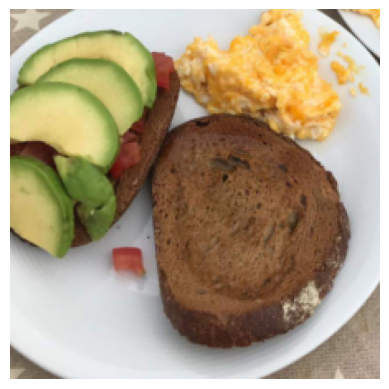

RECIPE 1

Title: Avocado egg salad sandwich

Ingredients:
avocado, bread, tomato, mayonnaise, pepper, egg, salt

Instructions:
-Toast bread.
-Spread mayonnaise on one side of each slice.
-Place avocado slices on one slice of bread.
-Top with tomato slices and salt and pepper.
-Top with other slice of bread.
RECIPE 2

Title: Egg salad sandwich with avocado (for adults)

Ingredients:
avocado, bread, tomato, mayonnaise, pepper, egg, salt

Instructions:
-Toast the bread.
-Smash the avocado.
-Put the bread on the plate, top with the tomato and season to taste with salt and pepper.
-I like the tomato, so i just put it on.
-Put the egg and mayonnaise (or egg) on the bread.
-Enjoy !
RECIPE 3

Title: Avocado and tomato sandwich

Ingredients:
avocado, bread, tomato, mayonnaise, pepper, egg, salt

Instructions:
-Toast bread.
-Spread mayonnaise on both sides of the bread and sprinkle with salt and pepper.
-Place avocado on top of mayonnaise.
-Place eggs on top of tomato, then tomato.
-Cut sandwich

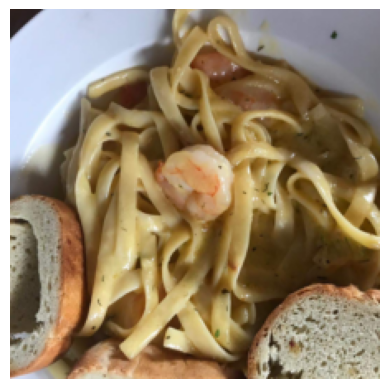

RECIPE 1

Title: Garlic shrimp scampi

Ingredients:
shrimp, pepper, butter, clove, oil, salt, pasta, parsley

Instructions:
-Heat olive oil in a large skillet over medium heat.
-Cook and stir garlic in hot oil until fragrant, about 1 minute.
-Stir shrimp into garlic; cook and stir until shrimp are pink and opaque, about 3 minutes.
-Season with salt and pepper.
-Stir butter into shrimp mixture until melted and sauce is heated through, about 2 minutes.
-Stir parsley into shrimp mixture; cook and stir until heated through, about 1 minute.
RECIPE 2

Title: Easy shrimp scampi

Ingredients:
shrimp, pepper, butter, clove, oil, salt, pasta, parsley

Instructions:
-Preheat oven to 425 degrees f (220 degrees c).
-In a large pot of salted boiling water, cook pasta until al dente; drain.
-Melt butter and olive oil together in a skillet, over medium heat, and stir in garlic.
-Cook for 1 minute.
-Stir parsley, salt, and pepper into the skillet mixture; cook and stir for 1 minute.
-Toss in shrimp, an

In [ ]:
for img_file in demo_files:

    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')

    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)

    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)

    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()

    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i],
                                   temperature=temperature, beam=beam[i], true_ingrs=None)

        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()

        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)

        if valid['is_valid'] or show_anyways:

            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])

            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])


In [ ]:
device